['Speed limit (20km/h)' 'Speed limit (30km/h)' 'Speed limit (50km/h)'
 'Speed limit (60km/h)' 'Speed limit (70km/h)' 'Speed limit (80km/h)'
 'End of speed limit (80km/h)' 'Speed limit (100km/h)'
 'Speed limit (120km/h)' 'No passing'
 'No passing for vechiles over 3.5 metric tons'
 'Right-of-way at the next intersection' 'Priority road' 'Yield' 'Stop'
 'No vechiles' 'Vechiles over 3.5 metric tons prohibited' 'No entry'
 'General caution' 'Dangerous curve to the left'
 'Dangerous curve to the right' 'Double curve' 'Bumpy road'
 'Slippery road' 'Road narrows on the right' 'Road work' 'Traffic signals'
 'Pedestrians' 'Children crossing' 'Bicycles crossing'
 'Beware of ice/snow' 'Wild animals crossing'
 'End of all speed and passing limits' 'Turn right ahead'
 'Turn left ahead' 'Ahead only' 'Go straight or right'
 'Go straight or left' 'Keep right' 'Keep left' 'Roundabout mandatory'
 'End of no passing' 'End of no passing by vechiles over 3.5 metric tons']


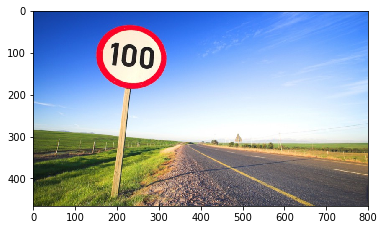

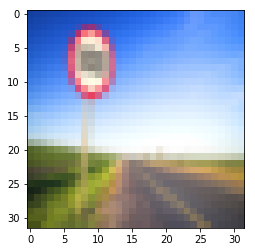

label=[Bicycles crossing] id=29 conf=0.4837172329425812
No Draw: label=[Bicycles crossing] id=29 conf=0.4837172329425812


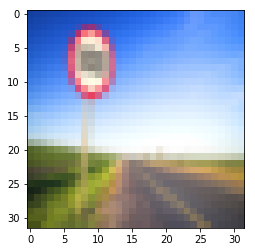

label=[Bicycles crossing] id=29 conf=0.4837172329425812
No Draw: label=[Bicycles crossing] id=29 conf=0.4837172329425812


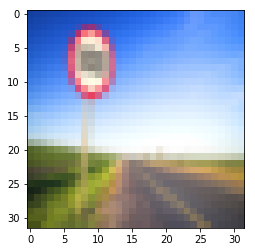

label=[Bicycles crossing] id=29 conf=0.4837172329425812
No Draw: label=[Bicycles crossing] id=29 conf=0.4837172329425812


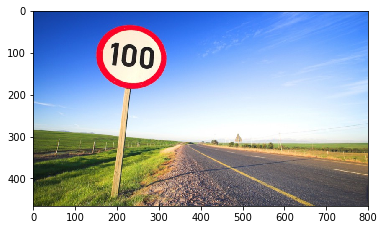

In [14]:
import os
import sys
import cv2
#brew install opencv
#pip install opencv-python
import numpy as np
from pandas import read_csv
#pip install moviepy
#pip install requests
from moviepy.editor import *
from matplotlib import pyplot as plt 
import keras
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.core import Activation, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
import tensorflow as tf
from scipy import misc


infile="../picture/v.mp4"
outfile="../picture/v-output.mp4"

'''
Code adapted from:
https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/

'''

IMG_SHAPE=[32,32,3]
INPUT_SHAPE=[1,32,32,3]
L2_LAMBDA = 0.0001   
WEIGTHS_PATH="../doc/weights_mltscl_dataaug.hdf5"
OUTPUT_DIM=43
LR = 0.0001
CONF_THRES=0.6

# Labels of circlur signs
cir_cls = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 16,
           17, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]

signnames = read_csv("../doc/signnames.csv").values[:, 1]

print(signnames)

def softmax(x):
    """
    Compute softmax values for each sets of scores in x.
    Ref: https://stackoverflow.com/questions/34968722/softmax-function-python
    """
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def build_mltscl():
    """
    Build multiscale CNN. The last layer must be logits instead of softmax.
    Return a compiled Keras model.
    """

    # Regularization
    l2_reg = keras.regularizers.l2(L2_LAMBDA)

    # Build model
    inpt = keras.layers.Input(shape=IMG_SHAPE)
    conv1 = keras.layers.Convolution2D(
        32, (5, 5), padding='same', activation='relu')(inpt)
    drop1 = keras.layers.Dropout(rate=0.1)(conv1)
    pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(drop1)

    conv2 = keras.layers.Convolution2D(
        64, (5, 5), padding='same', activation='relu')(pool1)
    drop2 = keras.layers.Dropout(rate=0.2)(conv2)
    pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(drop2)

    conv3 = keras.layers.Convolution2D(
        128, (5, 5), padding='same', activation='relu')(pool2)
    drop3 = keras.layers.Dropout(rate=0.3)(conv3)
    pool3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(drop3)

    pool4 = keras.layers.MaxPooling2D(pool_size=(4, 4))(pool1)
    pool5 = keras.layers.MaxPooling2D(pool_size=(2, 2))(pool2)

    flat1 = keras.layers.Flatten()(pool4)
    flat2 = keras.layers.Flatten()(pool5)
    flat3 = keras.layers.Flatten()(pool3)

    merge = keras.layers.Concatenate(axis=-1)([flat1, flat2, flat3])
    dense1 = keras.layers.Dense(1024, activation='relu',
                                kernel_regularizer=l2_reg)(merge)
    drop4 = keras.layers.Dropout(rate=0.5)(dense1)
    output = keras.layers.Dense(
        OUTPUT_DIM, activation=None, kernel_regularizer=l2_reg)(drop4)
    model = keras.models.Model(inputs=inpt, outputs=output)

    # Specify optimizer
    adam = keras.optimizers.Adam(
        lr=LR, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

model=build_mltscl()
model.load_weights(WEIGTHS_PATH)
#model.summary()

def rgb2gray(image):
    """Convert 3-channel RGB image into grayscale"""
    if image.ndim == 3:
        return (0.299 * image[:, :, 0] + 0.587 * image[:, :, 1] +
                0.114 * image[:, :, 2])
    elif image.ndim == 4:
        return (0.299 * image[:, :, :, 0] + 0.587 * image[:, :, :, 1] +
                0.114 * image[:, :, :, 2])

#识别原型的交通牌
def find_circles(img, mg_ratio=0.4, n_circles=1):
    """
    Find circular objects and return bounding boxes in the format
    [x1, y1, x2, y2]
    """

    targetImg = np.copy(img)
    targetImg = np.uint8(targetImg * 255)
    # Apply Gaussian blur if needed
    n = 13
    targetImg = cv2.GaussianBlur(targetImg, (n, n), 0)

    # Convert to grayscale
    grayImg = np.uint8(rgb2gray(targetImg))
    #grayImg = targetImg
    # param1 is canny threshold, param2 is circle accumulator threshold
    # Set of parameters for GTSDB testing
    # (because of different frame size and recording device)
    # circles = cv2.HoughCircles(grayImg, cv2.HOUGH_GRADIENT, 1, 200,
    #                            param1=60, param2=50, minRadius=5,
    #                            maxRadius=100)
    
    #通过调节minRadius=20,maxRadius=250设置可以检测的车牌大小
    circles = cv2.HoughCircles(grayImg, cv2.HOUGH_GRADIENT, 1, 200,
                               param1=50, param2=30, minRadius=20,
                               maxRadius=250)

    bboxes = []
    try:
        cir = circles.astype(np.uint16)
        for c in cir[0, :n_circles]:
            r = int(c[2])
            mg = int(r * mg_ratio)
            bboxes.append([c[0] - r - mg, c[1] - r - mg,
                           c[0] + r + mg, c[1] + r + mg])
    except AttributeError:
        pass
    except:
        raise
    return bboxes


def draw_bb(img, bbox, color=(0, 1, 0)):
    """Draw bounding box"""
    cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]),
                  color, 2)
    return img

def crop_bb(img, bbox):
    """Crop image by specifying bounding box"""
    bb = np.array(bbox)
    bb = bb * (bb > 0)
    return img[bb[1]:bb[3], bb[0]:bb[2], :]


def demo():
    
    demo_file="../picture/traffic_sign.jpeg"
    #OpenCV读取的格式为BGR 需要转换成RGB进行展现
    demo_img=cv2.imread(demo_file)
    demo_img=cv2.cvtColor(demo_img, cv2.COLOR_BGR2RGB) 
    show_img=demo_img.copy()
    plt.imshow(show_img) 
    plt.show() 
    
    #归一化 非常重要
    show_img=(show_img / 255.).astype(np.float32)
    
    bboxes = find_circles(show_img, mg_ratio=0.4, n_circles=3)
    for bbox in bboxes:
        crop = crop_bb(show_img, bbox)
        #resized_im = resize(crop)
        resized_im=misc.imresize(show_img, (32,32), interp="bilinear")
        
        plt.imshow(resized_im) 
        plt.show() 
        
        resized_im=resized_im.reshape(INPUT_SHAPE)
        resized_im=(resized_im / 255.).astype(np.float32)
        #print(resized_im)
        #resized_im =np.expand_dims(resized_im, axis=0)
        #label = signnames[predict(model, resized_im)]
        label = np.argmax(model.predict(resized_im)[0])
        conf = np.max(softmax(model.predict(resized_im)[0]))
        # Consider detection only if confidence is larger than threshold
        print("label=[{}] id={} conf={}".format(signnames[label],label,conf))
        if (conf > CONF_THRES ) and  (label in cir_cls) :
            print("Draw: label=[{}] id={} conf={}".format(signnames[label],label,conf))
            show_img = draw_bb(show_img, bbox)
            # Put label and confidence
            cv2.putText(show_img, '{}: {:.2f}'.format(signnames[label], conf), (bbox[0], bbox[1] - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 1, 0), 2)
        else:
            print('No Draw: label=[{}] id={} conf={}'.format(signnames[label],label, conf))

    
    show_img=np.uint8(show_img * 255)
    plt.imshow(show_img) 
    plt.show() 
demo()


In [2]:


#实现回调函数 处理每一帧图像
def invert_VideoFileClip(image):
  
    #归一化 非常重要
    show_img=(image.copy() / 255.).astype(np.float32)
    
   
    bboxes = find_circles(show_img, mg_ratio=0.4, n_circles=3)
    for bbox in bboxes:
        
        crop = crop_bb(show_img, bbox)
        #resized_im=cv2.resize(crop,(32,32))
        resized_im=misc.imresize(show_img, (32,32), interp="bilinear")

        #plt.imshow(resized_im) 
        #plt.show() 

        resized_im=resized_im.reshape(INPUT_SHAPE)
        #print(resized_im)
        #resized_im =np.expand_dims(resized_im, axis=0)
        #label = signnames[predict(model, resized_im)]
        label = np.argmax(model.predict(resized_im)[0])
        conf = np.max(softmax(model.predict(resized_im)[0]))
        # Consider detection only if confidence is larger than threshold
        print("label=[{}] id={} conf={}".format(signnames[label],label,conf))
        if (conf > CONF_THRES ) and  (label in cir_cls) :
            print("Draw: label=[{}] id={} conf={}".format(signnames[label],label,conf))
            show_img = draw_bb(show_img, bbox)
            # Put label and confidence
            cv2.putText(show_img, '{}: {:.2f}'.format(signnames[label], conf), (bbox[0], bbox[1] - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 1, 0), 2)
            

    show_img=np.uint8(show_img * 255)
    return show_img

clip = VideoFileClip(infile)
modifiedClip = clip.fl_image(invert_VideoFileClip)
modifiedClip.write_videofile(outfile)

label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
[MoviePy] >>>> Building video ../picture/v-output.mp4
[MoviePy] Writing audio in v-outputTEMP_MPY_wvf_snd.mp3


100%|██████████| 314/314 [00:00<00:00, 390.51it/s]


[MoviePy] Done.
[MoviePy] Writing video ../picture/v-output.mp4


  0%|          | 1/426 [00:00<01:05,  6.53it/s]

label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0


  1%|          | 3/426 [00:00<01:00,  6.96it/s]

label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0


  1%|          | 4/426 [00:00<01:00,  7.00it/s]

label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0


  1%|          | 5/426 [00:00<00:56,  7.46it/s]

label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0


  1%|▏         | 6/426 [00:00<00:58,  7.13it/s]

label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0


  2%|▏         | 7/426 [00:00<01:01,  6.79it/s]

label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0


  2%|▏         | 8/426 [00:01<01:04,  6.53it/s]

label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0


  2%|▏         | 9/426 [00:01<01:00,  6.95it/s]

label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0


  2%|▏         | 10/426 [00:01<00:59,  6.95it/s]

label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0


  3%|▎         | 12/426 [00:01<00:59,  6.96it/s]

label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0


  3%|▎         | 13/426 [00:01<00:55,  7.44it/s]

label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0


  3%|▎         | 14/426 [00:01<00:57,  7.14it/s]

label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0


  4%|▎         | 15/426 [00:02<00:57,  7.14it/s]

label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0


  4%|▍         | 17/426 [00:02<00:57,  7.09it/s]

label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0


  4%|▍         | 18/426 [00:02<00:57,  7.16it/s]

label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0


  5%|▍         | 21/426 [00:02<00:51,  7.90it/s]

label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0


  5%|▌         | 23/426 [00:03<00:50,  8.02it/s]

label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0


  6%|▌         | 25/426 [00:03<00:53,  7.54it/s]

label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0


  6%|▋         | 27/426 [00:03<00:47,  8.32it/s]

label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0


  7%|▋         | 29/426 [00:03<00:45,  8.74it/s]

label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0


  7%|▋         | 31/426 [00:04<00:43,  9.12it/s]

label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0


  8%|▊         | 33/426 [00:04<00:43,  9.05it/s]

label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0


  8%|▊         | 35/426 [00:04<00:41,  9.46it/s]

label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0


  9%|▊         | 37/426 [00:04<00:38, 10.07it/s]

label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0


 10%|▉         | 41/426 [00:05<00:38,  9.92it/s]

label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=0.9968735575675964
Draw: label=[Keep left] id=39 conf=0.9968735575675964


 10%|█         | 43/426 [00:05<00:38,  9.90it/s]

label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0


 11%|█         | 45/426 [00:05<00:39,  9.58it/s]

label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0


 11%|█         | 47/426 [00:05<00:41,  9.06it/s]

label=[Go straight or right] id=36 conf=0.7892895340919495
Draw: label=[Go straight or right] id=36 conf=0.7892895340919495
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 12%|█▏        | 49/426 [00:05<00:43,  8.76it/s]

label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0
label=[End of no passing] id=41 conf=0.9953852295875549
Draw: label=[End of no passing] id=41 conf=0.9953852295875549
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0


 12%|█▏        | 51/426 [00:06<00:45,  8.28it/s]

label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0
label=[Turn right ahead] id=33 conf=0.9997361302375793
Draw: label=[Turn right ahead] id=33 conf=0.9997361302375793
label=[Turn right ahead] id=33 conf=0.999946117401123
Draw: label=[Turn right ahead] id=33 conf=0.999946117401123
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0


 12%|█▏        | 52/426 [00:06<00:49,  7.61it/s]

label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0


 13%|█▎        | 54/426 [00:06<00:49,  7.54it/s]

label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0


 13%|█▎        | 55/426 [00:06<00:49,  7.52it/s]

label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0


 14%|█▎        | 58/426 [00:07<00:50,  7.29it/s]

label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0


 14%|█▍        | 59/426 [00:07<00:54,  6.77it/s]

label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0
label=[Go straight or right] id=36 conf=0.9994416832923889
Draw: label=[Go straight or right] id=36 conf=0.9994416832923889
label=[Go straight or right] id=36 conf=0.9999911785125732
Draw: label=[Go straight or right] id=36 conf=0.9999911785125732
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0


 14%|█▍        | 61/426 [00:07<00:55,  6.60it/s]

label=[Go straight or right] id=36 conf=0.9998327493667603
Draw: label=[Go straight or right] id=36 conf=0.9998327493667603
label=[Go straight or right] id=36 conf=0.9999982118606567
Draw: label=[Go straight or right] id=36 conf=0.9999982118606567
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0
label=[Turn left ahead] id=34 conf=1.0
Draw: label=[Turn left ahead] id=34 conf=1.0
label=[Turn left ahead] id=34 conf=1.0
Draw: label=[Turn left ahead] id=34 conf=1.0


 15%|█▍        | 63/426 [00:07<00:53,  6.79it/s]

label=[Turn left ahead] id=34 conf=1.0
Draw: label=[Turn left ahead] id=34 conf=1.0
label=[Turn left ahead] id=34 conf=0.9999933242797852
Draw: label=[Turn left ahead] id=34 conf=0.9999933242797852
label=[Turn left ahead] id=34 conf=1.0
Draw: label=[Turn left ahead] id=34 conf=1.0
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0


 15%|█▌        | 65/426 [00:08<00:52,  6.88it/s]

label=[Turn left ahead] id=34 conf=0.5757594704627991
label=[Turn left ahead] id=34 conf=0.5757594704627991
label=[Turn left ahead] id=34 conf=0.5757594704627991
label=[Turn right ahead] id=33 conf=0.9997333884239197
Draw: label=[Turn right ahead] id=33 conf=0.9997333884239197
label=[Turn left ahead] id=34 conf=1.0
Draw: label=[Turn left ahead] id=34 conf=1.0
label=[Turn left ahead] id=34 conf=0.999218225479126
Draw: label=[Turn left ahead] id=34 conf=0.999218225479126


 16%|█▌        | 67/426 [00:08<00:48,  7.34it/s]

label=[Turn right ahead] id=33 conf=0.9998781681060791
Draw: label=[Turn right ahead] id=33 conf=0.9998781681060791
label=[Turn left ahead] id=34 conf=0.99952232837677
Draw: label=[Turn left ahead] id=34 conf=0.99952232837677
label=[Go straight or right] id=36 conf=0.9999774694442749
Draw: label=[Go straight or right] id=36 conf=0.9999774694442749
label=[Go straight or right] id=36 conf=0.9997597336769104
Draw: label=[Go straight or right] id=36 conf=0.9997597336769104
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0


 16%|█▌        | 69/426 [00:08<00:46,  7.63it/s]

label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0
label=[Go straight or right] id=36 conf=0.976212203502655
Draw: label=[Go straight or right] id=36 conf=0.976212203502655
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0
label=[Go straight or right] id=36 conf=0.9907289743423462
Draw: label=[Go straight or right] id=36 conf=0.9907289743423462


 17%|█▋        | 71/426 [00:09<00:47,  7.43it/s]

label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0
label=[Go straight or right] id=36 conf=0.9999994039535522
Draw: label=[Go straight or right] id=36 conf=0.9999994039535522
label=[Keep left] id=39 conf=0.9962031245231628
Draw: label=[Keep left] id=39 conf=0.9962031245231628
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0


 17%|█▋        | 73/426 [00:09<00:48,  7.29it/s]

label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0


 18%|█▊        | 75/426 [00:09<00:46,  7.53it/s]

label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0


 18%|█▊        | 77/426 [00:09<00:45,  7.71it/s]

label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0
label=[Go straight or right] id=36 conf=0.9999996423721313
Draw: label=[Go straight or right] id=36 conf=0.9999996423721313
label=[End of no passing] id=41 conf=0.9951710104942322
Draw: label=[End of no passing] id=41 conf=0.9951710104942322


 19%|█▊        | 79/426 [00:10<00:46,  7.53it/s]

label=[End of no passing] id=41 conf=0.9999725818634033
Draw: label=[End of no passing] id=41 conf=0.9999725818634033
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0


 19%|█▉        | 81/426 [00:10<00:49,  6.95it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0


 19%|█▉        | 82/426 [00:10<00:53,  6.47it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0


 20%|█▉        | 85/426 [00:11<00:48,  6.96it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[Keep left] id=39 conf=0.8148319125175476
Draw: label=[Keep left] id=39 conf=0.8148319125175476
label=[Keep left] id=39 conf=0.9992702603340149
Draw: label=[Keep left] id=39 conf=0.9992702603340149


 20%|██        | 87/426 [00:11<00:46,  7.37it/s]

label=[End of no passing] id=41 conf=0.9999996423721313
Draw: label=[End of no passing] id=41 conf=0.9999996423721313
label=[Go straight or right] id=36 conf=0.767514169216156
Draw: label=[Go straight or right] id=36 conf=0.767514169216156
label=[Go straight or right] id=36 conf=0.5117977261543274
label=[Keep left] id=39 conf=0.779085636138916
Draw: label=[Keep left] id=39 conf=0.779085636138916
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0


 21%|██        | 89/426 [00:11<00:45,  7.43it/s]

label=[Keep left] id=39 conf=0.9999996423721313
Draw: label=[Keep left] id=39 conf=0.9999996423721313
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0


 21%|██▏       | 91/426 [00:11<00:43,  7.73it/s]

label=[End of no passing] id=41 conf=0.8590920567512512
Draw: label=[End of no passing] id=41 conf=0.8590920567512512
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[End of no passing] id=41 conf=0.9788419604301453
Draw: label=[End of no passing] id=41 conf=0.9788419604301453
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0


 22%|██▏       | 93/426 [00:12<00:43,  7.61it/s]

label=[End of no passing] id=41 conf=0.9897284507751465
Draw: label=[End of no passing] id=41 conf=0.9897284507751465
label=[End of no passing] id=41 conf=0.9999635219573975
Draw: label=[End of no passing] id=41 conf=0.9999635219573975
label=[End of no passing] id=41 conf=0.9999924898147583
Draw: label=[End of no passing] id=41 conf=0.9999924898147583
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0


 22%|██▏       | 94/426 [00:12<00:44,  7.45it/s]

label=[End of no passing] id=41 conf=0.9664530754089355
Draw: label=[End of no passing] id=41 conf=0.9664530754089355
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[End of no passing] id=41 conf=0.9996734857559204
Draw: label=[End of no passing] id=41 conf=0.9996734857559204
label=[Keep left] id=39 conf=0.989740252494812
Draw: label=[Keep left] id=39 conf=0.989740252494812
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0


 23%|██▎       | 96/426 [00:12<00:45,  7.24it/s]

label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=0.9655987024307251
Draw: label=[Keep left] id=39 conf=0.9655987024307251
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0


 23%|██▎       | 98/426 [00:12<00:41,  7.98it/s]

label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0


 23%|██▎       | 100/426 [00:12<00:41,  7.81it/s]

label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=0.9967953562736511
Draw: label=[Keep left] id=39 conf=0.9967953562736511
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[End of no passing] id=41 conf=0.6751357316970825
Draw: label=[End of no passing] id=41 conf=0.6751357316970825


 24%|██▍       | 102/426 [00:13<00:39,  8.29it/s]

label=[End of no passing] id=41 conf=0.9999940395355225
Draw: label=[End of no passing] id=41 conf=0.9999940395355225
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=0.7114183902740479
Draw: label=[Keep left] id=39 conf=0.7114183902740479
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0


 24%|██▍       | 104/426 [00:13<00:40,  8.01it/s]

label=[End of no passing] id=41 conf=0.9999485015869141
Draw: label=[End of no passing] id=41 conf=0.9999485015869141
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[Keep left] id=39 conf=0.9999998807907104
Draw: label=[Keep left] id=39 conf=0.9999998807907104


 25%|██▍       | 106/426 [00:13<00:38,  8.39it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[Keep left] id=39 conf=0.9999998807907104
Draw: label=[Keep left] id=39 conf=0.9999998807907104
label=[End of no passing] id=41 conf=0.9999914169311523
Draw: label=[End of no passing] id=41 conf=0.9999914169311523
label=[End of no passing] id=41 conf=0.9807259440422058
Draw: label=[End of no passing] id=41 conf=0.9807259440422058


 25%|██▌       | 108/426 [00:13<00:39,  8.08it/s]

label=[End of no passing] id=41 conf=0.9999545812606812
Draw: label=[End of no passing] id=41 conf=0.9999545812606812
label=[Bumpy road] id=22 conf=0.9425298571586609
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=0.99998939037323
Draw: label=[End of no passing] id=41 conf=0.99998939037323
label=[Keep left] id=39 conf=0.9742926359176636
Draw: label=[Keep left] id=39 conf=0.9742926359176636


 26%|██▌       | 110/426 [00:14<00:37,  8.51it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=0.9944531321525574
Draw: label=[End of no passing] id=41 conf=0.9944531321525574
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 26%|██▋       | 112/426 [00:14<00:40,  7.69it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=0.9999836683273315
Draw: label=[End of no passing] id=41 conf=0.9999836683273315
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0


 27%|██▋       | 114/426 [00:14<00:41,  7.48it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[Bumpy road] id=22 conf=1.0
label=[Bumpy road] id=22 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 27%|██▋       | 115/426 [00:14<00:43,  7.22it/s]

label=[End of no passing] id=41 conf=0.9999997615814209
Draw: label=[End of no passing] id=41 conf=0.9999997615814209
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[No entry] id=17 conf=0.8843820691108704
Draw: label=[No entry] id=17 conf=0.8843820691108704
label=[Stop] id=14 conf=0.5346739292144775
label=[Stop] id=14 conf=0.5346739292144775


 28%|██▊       | 118/426 [00:15<00:44,  6.99it/s]

label=[No entry] id=17 conf=1.0
Draw: label=[No entry] id=17 conf=1.0
label=[No entry] id=17 conf=1.0
Draw: label=[No entry] id=17 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[No entry] id=17 conf=1.0
Draw: label=[No entry] id=17 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[Stop] id=14 conf=1.0


 28%|██▊       | 120/426 [00:15<00:38,  7.85it/s]

label=[No entry] id=17 conf=0.6430491209030151
Draw: label=[No entry] id=17 conf=0.6430491209030151
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[Bicycles crossing] id=29 conf=0.7988496422767639
label=[Bicycles crossing] id=29 conf=0.7988496422767639


 29%|██▊       | 122/426 [00:15<00:37,  8.19it/s]

label=[No entry] id=17 conf=0.9999990463256836
Draw: label=[No entry] id=17 conf=0.9999990463256836
label=[No entry] id=17 conf=0.9978207349777222
Draw: label=[No entry] id=17 conf=0.9978207349777222
label=[No entry] id=17 conf=0.9999558925628662
Draw: label=[No entry] id=17 conf=0.9999558925628662
label=[No entry] id=17 conf=0.9999979734420776
Draw: label=[No entry] id=17 conf=0.9999979734420776


 29%|██▉       | 124/426 [00:16<00:38,  7.93it/s]

label=[Bicycles crossing] id=29 conf=0.7963903546333313
label=[Bicycles crossing] id=29 conf=0.7963903546333313
label=[Bicycles crossing] id=29 conf=0.9999984502792358
label=[Bicycles crossing] id=29 conf=0.9999984502792358
label=[Bicycles crossing] id=29 conf=0.9999984502792358


 30%|██▉       | 126/426 [00:16<00:36,  8.21it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[Bicycles crossing] id=29 conf=0.9968894124031067
label=[End of no passing] id=41 conf=0.9998254179954529
Draw: label=[End of no passing] id=41 conf=0.9998254179954529
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 30%|███       | 128/426 [00:16<00:36,  8.14it/s]

label=[End of no passing] id=41 conf=0.9791762828826904
Draw: label=[End of no passing] id=41 conf=0.9791762828826904
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 31%|███       | 130/426 [00:16<00:36,  8.19it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=0.9999961853027344
Draw: label=[End of no passing] id=41 conf=0.9999961853027344
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=0.9999998807907104
Draw: label=[End of no passing] id=41 conf=0.9999998807907104


 31%|███       | 132/426 [00:17<00:34,  8.52it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=0.9999041557312012
Draw: label=[End of no passing] id=41 conf=0.9999041557312012


 31%|███▏      | 134/426 [00:17<00:35,  8.12it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[No entry] id=17 conf=1.0
Draw: label=[No entry] id=17 conf=1.0
label=[No entry] id=17 conf=1.0
Draw: label=[No entry] id=17 conf=1.0


 32%|███▏      | 135/426 [00:17<00:34,  8.38it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[No entry] id=17 conf=1.0
Draw: label=[No entry] id=17 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=0.9252130389213562
Draw: label=[End of no passing] id=41 conf=0.9252130389213562


 33%|███▎      | 139/426 [00:17<00:29,  9.64it/s]

label=[No entry] id=17 conf=1.0
Draw: label=[No entry] id=17 conf=1.0
label=[Bumpy road] id=22 conf=0.9939296245574951
label=[Bumpy road] id=22 conf=1.0


 33%|███▎      | 141/426 [00:17<00:28, 10.14it/s]

label=[Bumpy road] id=22 conf=1.0
label=[Bumpy road] id=22 conf=1.0
label=[Bumpy road] id=22 conf=1.0


 34%|███▎      | 143/426 [00:18<00:26, 10.49it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 35%|███▍      | 147/426 [00:18<00:26, 10.47it/s]

label=[No entry] id=17 conf=1.0
Draw: label=[No entry] id=17 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 35%|███▍      | 149/426 [00:18<00:25, 10.78it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 36%|███▌      | 153/426 [00:19<00:25, 10.89it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 36%|███▋      | 155/426 [00:19<00:28,  9.49it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=0.9999399185180664
Draw: label=[End of no passing] id=41 conf=0.9999399185180664
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 37%|███▋      | 157/426 [00:19<00:29,  9.19it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 37%|███▋      | 159/426 [00:19<00:31,  8.58it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=0.9999997615814209
Draw: label=[End of no passing] id=41 conf=0.9999997615814209
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 38%|███▊      | 161/426 [00:20<00:33,  7.91it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
Draw: label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=0.9999996423721313
Draw: label=[End of no passing] id=41 conf=0.9999996423721313
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 38%|███▊      | 162/426 [00:20<00:36,  7.20it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=0.999998927116394
Draw: label=[End of no passing] id=41 conf=0.999998927116394
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 38%|███▊      | 164/426 [00:20<00:36,  7.22it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 39%|███▉      | 166/426 [00:20<00:32,  7.99it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 39%|███▉      | 167/426 [00:20<00:34,  7.59it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 40%|███▉      | 169/426 [00:21<00:33,  7.62it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 40%|████      | 171/426 [00:21<00:34,  7.41it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 41%|████      | 173/426 [00:21<00:35,  7.06it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
Draw: label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0


 41%|████      | 174/426 [00:21<00:36,  6.95it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 41%|████▏     | 176/426 [00:22<00:36,  6.76it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 42%|████▏     | 178/426 [00:22<00:35,  6.93it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 42%|████▏     | 180/426 [00:22<00:35,  6.92it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 43%|████▎     | 182/426 [00:22<00:32,  7.60it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 43%|████▎     | 184/426 [00:23<00:29,  8.25it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 44%|████▎     | 186/426 [00:23<00:27,  8.64it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 44%|████▍     | 188/426 [00:23<00:27,  8.58it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 45%|████▍     | 190/426 [00:23<00:25,  9.14it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 45%|████▌     | 193/426 [00:24<00:23,  9.73it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 46%|████▌     | 196/426 [00:24<00:23,  9.88it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 46%|████▋     | 198/426 [00:24<00:22, 10.30it/s]

label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
Draw: label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=0.913770318031311
Draw: label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=0.913770318031311
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 47%|████▋     | 202/426 [00:24<00:20, 10.94it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 48%|████▊     | 204/426 [00:25<00:20, 10.71it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 48%|████▊     | 206/426 [00:25<00:21, 10.46it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 49%|████▉     | 208/426 [00:25<00:21,  9.94it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=0.9999972581863403
Draw: label=[End of no passing] id=41 conf=0.9999972581863403
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 49%|████▉     | 210/426 [00:25<00:21,  9.87it/s]

label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
Draw: label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
Draw: label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
Draw: label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0


 50%|█████     | 214/426 [00:26<00:20, 10.33it/s]

label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
Draw: label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
Draw: label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
Draw: label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0


 51%|█████     | 216/426 [00:26<00:19, 10.54it/s]

label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
Draw: label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
Draw: label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 52%|█████▏    | 220/426 [00:26<00:19, 10.67it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 52%|█████▏    | 222/426 [00:26<00:20,  9.98it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 53%|█████▎    | 224/426 [00:27<00:19, 10.41it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 53%|█████▎    | 226/426 [00:27<00:19, 10.24it/s]

label=[Bicycles crossing] id=29 conf=0.9951679706573486
label=[Bicycles crossing] id=29 conf=1.0
label=[Bicycles crossing] id=29 conf=1.0
label=[Bicycles crossing] id=29 conf=1.0


 54%|█████▎    | 228/426 [00:27<00:20,  9.54it/s]

label=[Bicycles crossing] id=29 conf=1.0
label=[Bicycles crossing] id=29 conf=1.0
label=[Bicycles crossing] id=29 conf=1.0
label=[Bicycles crossing] id=29 conf=1.0


 54%|█████▍    | 232/426 [00:27<00:18, 10.43it/s]

label=[Bicycles crossing] id=29 conf=1.0
label=[Bicycles crossing] id=29 conf=1.0
label=[Bicycles crossing] id=29 conf=1.0
label=[Bicycles crossing] id=29 conf=1.0


 55%|█████▍    | 234/426 [00:28<00:19,  9.87it/s]

label=[Bicycles crossing] id=29 conf=0.9991924166679382
label=[Bicycles crossing] id=29 conf=0.9991924166679382
label=[End of no passing] id=41 conf=0.9999649524688721
Draw: label=[End of no passing] id=41 conf=0.9999649524688721
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0


 55%|█████▌    | 236/426 [00:28<00:19,  9.93it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 56%|█████▌    | 238/426 [00:28<00:19,  9.42it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 57%|█████▋    | 242/426 [00:28<00:18,  9.72it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 57%|█████▋    | 244/426 [00:29<00:20,  8.86it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=0.9999977350234985
Draw: label=[End of no passing] id=41 conf=0.9999977350234985
label=[Go straight or right] id=36 conf=0.9999548196792603
Draw: label=[Go straight or right] id=36 conf=0.9999548196792603
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0


 58%|█████▊    | 246/426 [00:29<00:21,  8.33it/s]

label=[Go straight or right] id=36 conf=0.9999995231628418
Draw: label=[Go straight or right] id=36 conf=0.9999995231628418
label=[Go straight or right] id=36 conf=0.9999998807907104
Draw: label=[Go straight or right] id=36 conf=0.9999998807907104
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0


 58%|█████▊    | 248/426 [00:29<00:22,  8.09it/s]

label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0
label=[Go straight or right] id=36 conf=0.9999185800552368
Draw: label=[Go straight or right] id=36 conf=0.9999185800552368
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0


 58%|█████▊    | 249/426 [00:29<00:21,  8.16it/s]

label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0
label=[End of no passing] id=41 conf=0.9999724626541138
Draw: label=[End of no passing] id=41 conf=0.9999724626541138
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0


 59%|█████▉    | 252/426 [00:30<00:20,  8.39it/s]

label=[End of no passing] id=41 conf=0.6700147986412048
Draw: label=[End of no passing] id=41 conf=0.6700147986412048
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0


 60%|█████▉    | 254/426 [00:30<00:21,  7.99it/s]

label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0
label=[Go straight or right] id=36 conf=0.9999983310699463
Draw: label=[Go straight or right] id=36 conf=0.9999983310699463


 60%|██████    | 256/426 [00:30<00:21,  8.06it/s]

label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0


 61%|██████    | 258/426 [00:30<00:20,  8.13it/s]

label=[End of no passing] id=41 conf=0.939324676990509
Draw: label=[End of no passing] id=41 conf=0.939324676990509
label=[End of no passing] id=41 conf=0.8209925293922424
Draw: label=[End of no passing] id=41 conf=0.8209925293922424
label=[Go straight or right] id=36 conf=1.0
Draw: label=[Go straight or right] id=36 conf=1.0


 61%|██████    | 260/426 [00:31<00:20,  8.27it/s]

label=[Go straight or right] id=36 conf=0.9999730587005615
Draw: label=[Go straight or right] id=36 conf=0.9999730587005615
label=[Turn right ahead] id=33 conf=1.0
Draw: label=[Turn right ahead] id=33 conf=1.0
label=[Turn right ahead] id=33 conf=0.999996542930603
Draw: label=[Turn right ahead] id=33 conf=0.999996542930603
label=[Turn right ahead] id=33 conf=1.0
Draw: label=[Turn right ahead] id=33 conf=1.0


 61%|██████▏   | 261/426 [00:31<00:21,  7.62it/s]

label=[Turn right ahead] id=33 conf=1.0
Draw: label=[Turn right ahead] id=33 conf=1.0
label=[Turn right ahead] id=33 conf=1.0
Draw: label=[Turn right ahead] id=33 conf=1.0
label=[Turn right ahead] id=33 conf=1.0
Draw: label=[Turn right ahead] id=33 conf=1.0
label=[Turn right ahead] id=33 conf=0.7465607523918152
Draw: label=[Turn right ahead] id=33 conf=0.7465607523918152


 62%|██████▏   | 264/426 [00:31<00:19,  8.45it/s]

label=[Turn right ahead] id=33 conf=1.0
Draw: label=[Turn right ahead] id=33 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=0.999010443687439
Draw: label=[End of no passing] id=41 conf=0.999010443687439


 62%|██████▏   | 266/426 [00:31<00:19,  8.04it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[Turn right ahead] id=33 conf=0.9947924017906189
Draw: label=[Turn right ahead] id=33 conf=0.9947924017906189
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=0.9999991655349731
Draw: label=[End of no passing] id=41 conf=0.9999991655349731


 63%|██████▎   | 268/426 [00:32<00:19,  8.28it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=0.9952107071876526
Draw: label=[End of no passing] id=41 conf=0.9952107071876526


 63%|██████▎   | 270/426 [00:32<00:18,  8.32it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 64%|██████▎   | 271/426 [00:32<00:19,  8.03it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 64%|██████▍   | 274/426 [00:32<00:17,  8.64it/s]

label=[End of no passing] id=41 conf=0.9999997615814209
Draw: label=[End of no passing] id=41 conf=0.9999997615814209
label=[End of no passing] id=41 conf=0.9845364689826965
Draw: label=[End of no passing] id=41 conf=0.9845364689826965


 65%|██████▍   | 276/426 [00:32<00:16,  9.29it/s]

label=[Turn right ahead] id=33 conf=1.0
Draw: label=[Turn right ahead] id=33 conf=1.0
label=[Turn right ahead] id=33 conf=1.0
Draw: label=[Turn right ahead] id=33 conf=1.0
label=[Turn right ahead] id=33 conf=1.0
Draw: label=[Turn right ahead] id=33 conf=1.0


 65%|██████▌   | 277/426 [00:33<00:16,  9.05it/s]

label=[Turn right ahead] id=33 conf=1.0
Draw: label=[Turn right ahead] id=33 conf=1.0
label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=0.7238466143608093
Draw: label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=0.7238466143608093
label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
Draw: label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
label=[Turn right ahead] id=33 conf=1.0
Draw: label=[Turn right ahead] id=33 conf=1.0


 66%|██████▌   | 280/426 [00:33<00:16,  8.93it/s]

label=[Turn right ahead] id=33 conf=1.0
Draw: label=[Turn right ahead] id=33 conf=1.0
label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
Draw: label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 66%|██████▌   | 282/426 [00:33<00:15,  9.04it/s]

label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
Draw: label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
Draw: label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
label=[Turn right ahead] id=33 conf=0.8279238343238831
Draw: label=[Turn right ahead] id=33 conf=0.8279238343238831


 67%|██████▋   | 284/426 [00:33<00:16,  8.68it/s]

label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
Draw: label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=0.5666443705558777
label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=0.5666443705558777


 67%|██████▋   | 286/426 [00:34<00:16,  8.54it/s]

label=[Turn right ahead] id=33 conf=1.0
Draw: label=[Turn right ahead] id=33 conf=1.0
label=[Turn right ahead] id=33 conf=1.0
Draw: label=[Turn right ahead] id=33 conf=1.0
label=[Turn right ahead] id=33 conf=1.0
Draw: label=[Turn right ahead] id=33 conf=1.0
label=[Turn right ahead] id=33 conf=1.0
Draw: label=[Turn right ahead] id=33 conf=1.0


 68%|██████▊   | 288/426 [00:34<00:16,  8.33it/s]

label=[Turn right ahead] id=33 conf=1.0
Draw: label=[Turn right ahead] id=33 conf=1.0
label=[Turn right ahead] id=33 conf=1.0
Draw: label=[Turn right ahead] id=33 conf=1.0
label=[Turn right ahead] id=33 conf=1.0
Draw: label=[Turn right ahead] id=33 conf=1.0
label=[Turn right ahead] id=33 conf=1.0
Draw: label=[Turn right ahead] id=33 conf=1.0
label=[Turn right ahead] id=33 conf=1.0
Draw: label=[Turn right ahead] id=33 conf=1.0


 68%|██████▊   | 290/426 [00:34<00:16,  8.36it/s]

label=[End of no passing] id=41 conf=0.9999959468841553
Draw: label=[End of no passing] id=41 conf=0.9999959468841553
label=[Turn right ahead] id=33 conf=1.0
Draw: label=[Turn right ahead] id=33 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[Turn right ahead] id=33 conf=1.0
Draw: label=[Turn right ahead] id=33 conf=1.0


 69%|██████▊   | 292/426 [00:34<00:16,  8.19it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[Turn right ahead] id=33 conf=1.0
Draw: label=[Turn right ahead] id=33 conf=1.0
label=[Turn right ahead] id=33 conf=1.0
Draw: label=[Turn right ahead] id=33 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[Turn right ahead] id=33 conf=1.0
Draw: label=[Turn right ahead] id=33 conf=1.0


 69%|██████▉   | 294/426 [00:35<00:15,  8.59it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 69%|██████▉   | 296/426 [00:35<00:15,  8.56it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[Turn right ahead] id=33 conf=1.0
Draw: label=[Turn right ahead] id=33 conf=1.0


 70%|██████▉   | 297/426 [00:35<00:15,  8.59it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[Turn right ahead] id=33 conf=0.9999523162841797
Draw: label=[Turn right ahead] id=33 conf=0.9999523162841797
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 70%|███████   | 300/426 [00:35<00:13,  9.16it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[Turn right ahead] id=33 conf=1.0
Draw: label=[Turn right ahead] id=33 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 71%|███████   | 302/426 [00:35<00:15,  8.19it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[Turn right ahead] id=33 conf=1.0
Draw: label=[Turn right ahead] id=33 conf=1.0
label=[Turn right ahead] id=33 conf=1.0
Draw: label=[Turn right ahead] id=33 conf=1.0


 71%|███████   | 303/426 [00:36<00:14,  8.26it/s]

label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Turn right ahead] id=33 conf=1.0
Draw: label=[Turn right ahead] id=33 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0


 72%|███████▏  | 306/426 [00:36<00:13,  8.57it/s]

label=[Keep left] id=39 conf=0.9999986886978149
Draw: label=[Keep left] id=39 conf=0.9999986886978149
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Go straight or right] id=36 conf=0.9634719491004944
Draw: label=[Go straight or right] id=36 conf=0.9634719491004944
label=[End of no passing] id=41 conf=0.9999744892120361
Draw: label=[End of no passing] id=41 conf=0.9999744892120361


 72%|███████▏  | 308/426 [00:36<00:15,  7.79it/s]

label=[Go straight or right] id=36 conf=0.6641183495521545
Draw: label=[Go straight or right] id=36 conf=0.6641183495521545
label=[Turn right ahead] id=33 conf=1.0
Draw: label=[Turn right ahead] id=33 conf=1.0
label=[Turn right ahead] id=33 conf=1.0
Draw: label=[Turn right ahead] id=33 conf=1.0
label=[Go straight or right] id=36 conf=0.6641183495521545
Draw: label=[Go straight or right] id=36 conf=0.6641183495521545
label=[Turn right ahead] id=33 conf=1.0
Draw: label=[Turn right ahead] id=33 conf=1.0
label=[Turn right ahead] id=33 conf=1.0
Draw: label=[Turn right ahead] id=33 conf=1.0


 73%|███████▎  | 310/426 [00:36<00:14,  8.05it/s]

label=[End of no passing] id=41 conf=0.7951808571815491
Draw: label=[End of no passing] id=41 conf=0.7951808571815491
label=[Go straight or right] id=36 conf=0.9999868869781494
Draw: label=[Go straight or right] id=36 conf=0.9999868869781494
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 73%|███████▎  | 312/426 [00:37<00:13,  8.29it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[Stop] id=14 conf=0.6693464517593384
label=[Stop] id=14 conf=0.6693464517593384


 74%|███████▎  | 314/426 [00:37<00:13,  8.58it/s]

label=[Stop] id=14 conf=0.9999947547912598
label=[Stop] id=14 conf=0.9999947547912598
label=[Stop] id=14 conf=0.9999998807907104


 74%|███████▍  | 316/426 [00:37<00:11,  9.19it/s]

label=[Stop] id=14 conf=0.9999992847442627
label=[Go straight or right] id=36 conf=0.7086915969848633
Draw: label=[Go straight or right] id=36 conf=0.7086915969848633
label=[Turn right ahead] id=33 conf=1.0
Draw: label=[Turn right ahead] id=33 conf=1.0


 75%|███████▍  | 319/426 [00:37<00:12,  8.91it/s]

label=[Turn right ahead] id=33 conf=1.0
Draw: label=[Turn right ahead] id=33 conf=1.0
label=[Turn right ahead] id=33 conf=1.0
Draw: label=[Turn right ahead] id=33 conf=1.0
label=[Turn right ahead] id=33 conf=1.0
Draw: label=[Turn right ahead] id=33 conf=1.0
label=[End of no passing] id=41 conf=0.8240064978599548
Draw: label=[End of no passing] id=41 conf=0.8240064978599548


 75%|███████▌  | 321/426 [00:38<00:10,  9.57it/s]

label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
Draw: label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
Draw: label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
Draw: label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0


 76%|███████▌  | 324/426 [00:38<00:10,  9.78it/s]

label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
Draw: label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
Draw: label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
Draw: label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0


 77%|███████▋  | 326/426 [00:38<00:10,  9.52it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
Draw: label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0


 77%|███████▋  | 328/426 [00:38<00:10,  9.55it/s]

label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
Draw: label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
Draw: label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
Draw: label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0


 78%|███████▊  | 331/426 [00:39<00:10,  8.91it/s]

label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
Draw: label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=0.9962648749351501
Draw: label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=0.9962648749351501
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 78%|███████▊  | 333/426 [00:39<00:09,  9.52it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[Keep left] id=39 conf=0.9999994039535522
Draw: label=[Keep left] id=39 conf=0.9999994039535522
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0


 79%|███████▉  | 336/426 [00:39<00:10,  8.65it/s]

label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=0.9999946355819702
Draw: label=[Keep left] id=39 conf=0.9999946355819702


 79%|███████▉  | 338/426 [00:39<00:09,  8.84it/s]

label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=0.9581845998764038
Draw: label=[Keep left] id=39 conf=0.9581845998764038
label=[Turn right ahead] id=33 conf=1.0
Draw: label=[Turn right ahead] id=33 conf=1.0


 80%|███████▉  | 340/426 [00:40<00:09,  9.10it/s]

label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0
label=[Keep left] id=39 conf=1.0
Draw: label=[Keep left] id=39 conf=1.0


 80%|████████  | 341/426 [00:40<00:09,  8.83it/s]

label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=0.9999823570251465
Draw: label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=0.9999823570251465
label=[Turn right ahead] id=33 conf=1.0
Draw: label=[Turn right ahead] id=33 conf=1.0
label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
Draw: label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0


 81%|████████  | 344/426 [00:40<00:08,  9.43it/s]

label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
Draw: label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
label=[Bicycles crossing] id=29 conf=1.0
label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
Draw: label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0


 81%|████████▏ | 347/426 [00:40<00:08,  9.56it/s]

label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
Draw: label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
label=[Keep left] id=39 conf=0.6292336583137512
Draw: label=[Keep left] id=39 conf=0.6292336583137512


 82%|████████▏ | 349/426 [00:40<00:07, 10.05it/s]

label=[Bicycles crossing] id=29 conf=0.9999947547912598
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[Bicycles crossing] id=29 conf=0.99997878074646


 83%|████████▎ | 352/426 [00:41<00:07,  9.51it/s]

label=[End of no passing] id=41 conf=0.9999978542327881
Draw: label=[End of no passing] id=41 conf=0.9999978542327881
label=[Bicycles crossing] id=29 conf=1.0
label=[Bicycles crossing] id=29 conf=1.0
label=[Bicycles crossing] id=29 conf=1.0


 83%|████████▎ | 354/426 [00:41<00:07,  9.12it/s]

label=[Children crossing] id=28 conf=1.0
label=[Children crossing] id=28 conf=1.0
label=[Children crossing] id=28 conf=1.0


 83%|████████▎ | 355/426 [00:41<00:08,  8.81it/s]

label=[Bicycles crossing] id=29 conf=1.0
label=[Bicycles crossing] id=29 conf=1.0
label=[Bicycles crossing] id=29 conf=1.0


 84%|████████▍ | 358/426 [00:41<00:07,  9.24it/s]

label=[Bicycles crossing] id=29 conf=1.0
label=[Bicycles crossing] id=29 conf=1.0
label=[Bicycles crossing] id=29 conf=1.0


 85%|████████▍ | 361/426 [00:42<00:07,  8.62it/s]

label=[Bicycles crossing] id=29 conf=1.0
label=[Bicycles crossing] id=29 conf=1.0
label=[Bicycles crossing] id=29 conf=1.0


 85%|████████▍ | 362/426 [00:42<00:07,  8.72it/s]

label=[Bicycles crossing] id=29 conf=1.0
label=[Bumpy road] id=22 conf=0.8622393012046814


 86%|████████▌ | 365/426 [00:42<00:07,  8.63it/s]

label=[Bicycles crossing] id=29 conf=0.9981775283813477
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 86%|████████▌ | 367/426 [00:43<00:07,  8.27it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 87%|████████▋ | 369/426 [00:43<00:06,  8.24it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 87%|████████▋ | 371/426 [00:43<00:06,  8.14it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 88%|████████▊ | 373/426 [00:43<00:06,  8.38it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 88%|████████▊ | 375/426 [00:43<00:05,  8.63it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 88%|████████▊ | 377/426 [00:44<00:05,  8.59it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 89%|████████▊ | 378/426 [00:44<00:05,  8.89it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
Draw: label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
Draw: label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0


 89%|████████▉ | 381/426 [00:44<00:05,  8.36it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
Draw: label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 90%|████████▉ | 383/426 [00:44<00:05,  8.25it/s]

label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
Draw: label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
Draw: label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
Draw: label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 90%|█████████ | 385/426 [00:45<00:04,  8.30it/s]

label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=0.9629092216491699
Draw: label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=0.9629092216491699
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 91%|█████████ | 387/426 [00:45<00:04,  8.59it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 91%|█████████▏| 389/426 [00:45<00:04,  8.87it/s]

label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=0.9314858913421631
Draw: label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=0.9314858913421631
label=[End of no passing] id=41 conf=0.9999998807907104
Draw: label=[End of no passing] id=41 conf=0.9999998807907104
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 92%|█████████▏| 391/426 [00:45<00:04,  8.35it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 92%|█████████▏| 393/426 [00:46<00:04,  7.72it/s]

label=[Keep left] id=39 conf=0.9999889135360718
Draw: label=[Keep left] id=39 conf=0.9999889135360718
label=[End of no passing] id=41 conf=0.9999980926513672
Draw: label=[End of no passing] id=41 conf=0.9999980926513672
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 93%|█████████▎| 395/426 [00:46<00:04,  7.27it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 93%|█████████▎| 397/426 [00:46<00:04,  7.12it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 94%|█████████▎| 399/426 [00:46<00:03,  7.06it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 94%|█████████▍| 400/426 [00:47<00:03,  6.92it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 94%|█████████▍| 402/426 [00:47<00:03,  6.64it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 95%|█████████▍| 404/426 [00:47<00:03,  7.03it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 95%|█████████▌| 405/426 [00:47<00:03,  6.74it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 96%|█████████▌| 407/426 [00:48<00:02,  7.34it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 96%|█████████▋| 411/426 [00:48<00:01,  8.72it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 97%|█████████▋| 413/426 [00:48<00:01,  9.36it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 98%|█████████▊| 416/426 [00:49<00:01,  8.65it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 98%|█████████▊| 418/426 [00:49<00:01,  7.69it/s]

label=[End of no passing] id=41 conf=0.9999995231628418
Draw: label=[End of no passing] id=41 conf=0.9999995231628418
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 99%|█████████▊| 420/426 [00:49<00:00,  7.87it/s]

label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[Right-of-way at the next intersection] id=11 conf=1.0
label=[Right-of-way at the next intersection] id=11 conf=1.0


 99%|█████████▉| 422/426 [00:49<00:00,  7.84it/s]

label=[Right-of-way at the next intersection] id=11 conf=1.0
label=[Right-of-way at the next intersection] id=11 conf=1.0
label=[Right-of-way at the next intersection] id=11 conf=1.0
label=[Right-of-way at the next intersection] id=11 conf=1.0
label=[Right-of-way at the next intersection] id=11 conf=1.0


100%|█████████▉| 424/426 [00:50<00:00,  7.26it/s]

label=[Right-of-way at the next intersection] id=11 conf=1.0
label=[Right-of-way at the next intersection] id=11 conf=1.0
label=[Right-of-way at the next intersection] id=11 conf=1.0
label=[Right-of-way at the next intersection] id=11 conf=1.0
label=[Right-of-way at the next intersection] id=11 conf=1.0
label=[Right-of-way at the next intersection] id=11 conf=1.0


100%|██████████| 426/426 [00:50<00:00,  7.43it/s]

label=[End of no passing] id=41 conf=0.9128838181495667
Draw: label=[End of no passing] id=41 conf=0.9128838181495667
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../picture/v-output.mp4 

